<a href="https://colab.research.google.com/github/casjunior93/Desafio-DIO-Sistema-de-Recomendacao-por-Imagens-Digitais/blob/main/Sistema_de_Recomenda%C3%A7%C3%A3o_por_Imagens_Digitais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Criando um Sistema de Recomendação por Imagens Digitais

## 1. Bibliotecas

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shutil import move
import os
from tqdm import tqdm
import tensorflow as tf
from pathlib import Path
#tqdm é um pacote para Python que permite criar instantaneamente 
#barras de progresso e estimar TTC (Time To Completion) para suas funções e loops! 
tqdm.pandas()

## 2. Habiltando Google Drive

In [2]:
%%time
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
CPU times: user 1.25 s, sys: 255 ms, total: 1.51 s
Wall time: 30.2 s


## 3. Importando biblioteca do Kaggle e minhas credenciais.

In [4]:
%%time
!pip install -q -U kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached kaggle-1.5.13-py3-none-any.whl
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.13
    Uninstalling kaggle-1.5.13:
      Successfully uninstalled kaggle-1.5.13
mkdir: cannot create directory ‘/root/.kaggle’: File exists
CPU times: user 119 ms, sys: 59.6 ms, total: 178 ms
Wall time: 15.1 s


## 4. Obtendo os dados

In [ ]:
%%time
!kaggle datasets download -d paramaggarwal/fashion-product-images-small
!unzip fashion-product-images-small.zip

Aqui criamos o diretorio que vai conter nossas imagens e as categorias.

In [6]:
%%time
os.mkdir('/content/Fashion_data')
os.chdir('/content/Fashion_data')

df = pd.read_csv('/content/styles.csv', usecols=['id','masterCategory']).reset_index()
df['id'] = df['id'].astype('str')

all_images = os.listdir('/content/images/')
co = 0
os.mkdir('/content/Fashion_data/categories')
for image in tqdm(all_images):
    category = df[df['id'] == image.split('.')[0]]['masterCategory']
    category = str(list(category)[0])
    if not os.path.exists(os.path.join('/content/Fashion_data/categories', category)):
        os.mkdir(os.path.join('/content/Fashion_data/categories', category))
    path_from = os.path.join('/content/images', image)
    path_to = os.path.join('/content/Fashion_data/categories', category, image)
    move(path_from, path_to)
    co += 1
print('Moved {} images.'.format(co))

100%|██████████| 44441/44441 [02:44<00:00, 270.63it/s]

Moved 44441 images.
CPU times: user 2min 36s, sys: 3.95 s, total: 2min 40s
Wall time: 2min 44s


## 5. Transferência de aprendizado

Baixando o modelo de imagem pré-treinado e adicionando duas camadas adicionais: a primeira camada é uma camada de vetor de recursos e a segunda camada é a camada de classificação. Vamos treinar apenas essas 2 camadas em nossos dados e, após o treinamento, selecionaremos a camada de vetor de recursos como saída de nosso codificador ajustado. Depois de ajustar o modelo, salvaremos o extrator de recursos para uso posterior.

In [ ]:
%%time
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.12.0
Hub version: 0.13.0
GPU is available
CPU times: user 2.36 s, sys: 404 ms, total: 2.77 s
Wall time: 3.16 s


In [ ]:
%%time
MODULE_HANDLE = 'https://tfhub.dev/google/bit/m-r50x3/1'
IMAGE_SIZE = (224, 224)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))
BATCH_SIZE = 32 
N_FEATURES = 256

Using https://tfhub.dev/google/bit/m-r50x3/1 with input size (224, 224)
CPU times: user 511 µs, sys: 15 µs, total: 526 µs
Wall time: 414 µs


In [ ]:
%%time
data_dir = '/content/Fashion_data/categories'

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.29 µs


In [ ]:
%%time
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=False, **dataflow_kwargs)

do_data_augmentation = False 
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True, **dataflow_kwargs)

Found 8886 images belonging to 7 classes.
Found 35555 images belonging to 7 classes.
CPU times: user 738 ms, sys: 192 ms, total: 931 ms
Wall time: 796 ms


Construindo o modelo com Keras

In [ ]:
%%time
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(MODULE_HANDLE, trainable=False),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(N_FEATURES,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/bit/m-r50x3/1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 6144)              211174080 
                                                                 
 dropout (Dropout)           (None, 6144)              0         
                                                                 
 dense (Dense)               (None, 256)               1573120   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 212,748,999
Trainable params: 1,574,919
Non-trainable params: 211,174,080
_________________________________________

Compilando o modelo

In [ ]:
%%time
# Define optimiser and loss
lr = 0.003 * BATCH_SIZE / 512 
SCHEDULE_LENGTH = 500
SCHEDULE_BOUNDARIES = [200, 300, 400]

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES, 
                                                                   values=[lr, lr*0.1, lr*0.001, lr*0.0001])
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

CPU times: user 30.3 ms, sys: 1.07 ms, total: 31.4 ms
Wall time: 66.1 ms


Treinando o modelo

In [ ]:
%%time
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model.fit(
    train_generator,
    epochs=5, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps).history

Epoch 1/5
1111/1111 [==============================] - 1317s 1s/step - loss: 0.2533 - accuracy: 0.9681 - val_loss: 0.1394 - val_accuracy: 0.9904
Epoch 2/5
1111/1111 [==============================] - 1298s 1s/step - loss: 0.1946 - accuracy: 0.9762 - val_loss: 0.1393 - val_accuracy: 0.9903
Epoch 3/5
1111/1111 [==============================] - 1299s 1s/step - loss: 0.1976 - accuracy: 0.9768 - val_loss: 0.1392 - val_accuracy: 0.9904
Epoch 4/5
1111/1111 [==============================] - 1299s 1s/step - loss: 0.2003 - accuracy: 0.9758 - val_loss: 0.1391 - val_accuracy: 0.9904
Epoch 5/5
1111/1111 [==============================] - 1299s 1s/step - loss: 0.1947 - accuracy: 0.9768 - val_loss: 0.1390 - val_accuracy: 0.9904
CPU times: user 17min 31s, sys: 5min 27s, total: 22min 58s
Wall time: 1h 51min 20s


Perda e acurácia durante o treinamento do modelo.

CPU times: user 48.8 ms, sys: 0 ns, total: 48.8 ms
Wall time: 72.1 ms


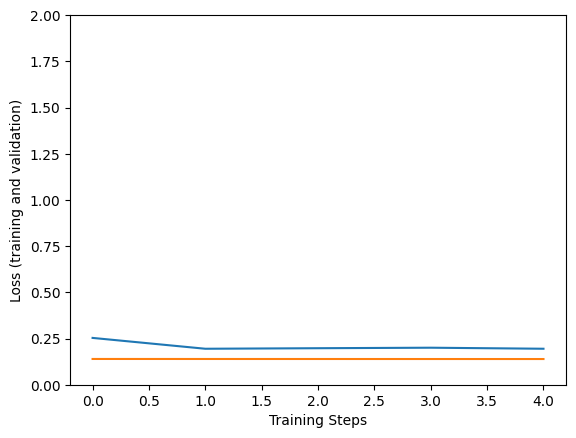

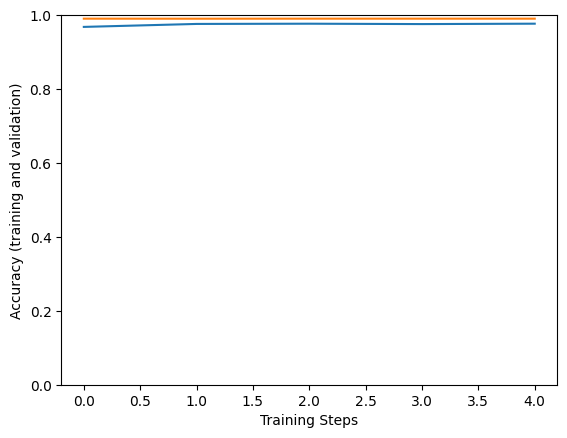

In [ ]:
%%time
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

Salvando o modelo:

In [ ]:
%%time
if not os.path.exists('/content/drive/MyDrive/ImgSim/'):
    os.mkdir('/content/drive/MyDrive/ImgSim/')

feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-3].output)
feature_extractor.save('/content/drive/MyDrive/ImgSim/bit_feature_extractor', save_format='tf')

saved_model_path = '/content/drive/MyDrive/ImgSim/bit_model'
tf.saved_model.save(model, saved_model_path)

CPU times: user 30.2 s, sys: 2.65 s, total: 32.8 s
Wall time: 40.7 s


## 6. Vetorização dos dados

Agora, usaremos o codificador (preparado no passo 3) para codificar as imagens (preparado no passo 2). Salvaremos o vetor de recursos de cada imagem como uma matriz em um diretório. Após o processamento, salvaremos essas incorporações para uso posterior.

In [11]:
%%time
img_paths = []
for path in Path('/content/Fashion_data/categories').rglob('*.jpg'):
  img_paths.append(path)
np.random.shuffle(img_paths)

CPU times: user 428 ms, sys: 40.2 ms, total: 468 ms
Wall time: 468 ms


In [12]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img, channels=3)
  img = tf.image.resize_with_pad(img, 224, 224)
  img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  return img

Recuperando o modelo que treinamos anteriormente.

In [14]:
%%time
TRANSFER_LEARNING_FLAG = 1
if TRANSFER_LEARNING_FLAG:
  module = tf.keras.models.load_model('/content/drive/MyDrive/ImgSim/bit_feature_extractor')
else:
  module_handle = "https://tfhub.dev/google/bit/s-r50x3/ilsvrc2012_classification/1" 
  module = hub.load(module_handle)

CPU times: user 22.1 s, sys: 1.84 s, total: 23.9 s
Wall time: 36.9 s


Vetorizando as imagens

In [17]:
%%time
imgvec_path = '/content/img_vectors/'
Path(imgvec_path).mkdir(parents=True, exist_ok=True)

CPU times: user 241 µs, sys: 11 µs, total: 252 µs
Wall time: 3.56 ms


In [18]:
%%time
for filename in tqdm(img_paths[:5000]):
    img = load_img(str(filename))
    features = module(img)
    feature_set = np.squeeze(features)
    outfile_name = os.path.basename(filename).split('.')[0] + ".npz"
    out_path_file = os.path.join(imgvec_path, outfile_name)
    np.savetxt(out_path_file, feature_set, delimiter=',')

100%|██████████| 5000/5000 [09:49<00:00,  8.49it/s]

CPU times: user 8min 44s, sys: 31.5 s, total: 9min 16s
Wall time: 9min 49s


## 7. Metadados e indexação

Atribuiremos um id exclusivo a cada imagem e criaremos dicionários para localizar as informações dessa imagem: 1) ID da imagem para o dicionário de nome da imagem, 2) ID da imagem para o dicionário de vetores de recursos da imagem e 3) (opcional) ID da imagem para ID do produto de metadados dicionário. Também criaremos um ID de imagem para a indexação de vetores de recursos de imagem. Em seguida, salvaremos esses dicionários e objetos de índice para uso posterior.

In [19]:
import glob
!pip install -q annoy #https://sds-aau.github.io/M3Port19/portfolio/ann/
import json
from annoy import AnnoyIndex
from scipy import spatial
import pickle
from IPython.display import Image as dispImage

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.4/647.4 kB 39.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


Testando visualização de imagem;

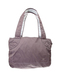

In [20]:
test_img = '/content/Fashion_data/categories/Accessories/1941.jpg'
dispImage(test_img)

In [22]:
%%time
root_path = '/content/drive/MyDrive/ImgSim'
styles = pd.read_csv('/content/styles.csv', error_bad_lines=False)
styles['id'] = styles['id'].astype('str')
styles.to_csv(root_path+'/styles.csv', index=False)

<timed exec>:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


Skipping line 6044: expected 10 fields, saw 11
Skipping line 6569: expected 10 fields, saw 11
Skipping line 7399: expected 10 fields, saw 11
Skipping line 7939: expected 10 fields, saw 11
Skipping line 9026: expected 10 fields, saw 11
Skipping line 10264: expected 10 fields, saw 11
Skipping line 10427: expected 10 fields, saw 11
Skipping line 10905: expected 10 fields, saw 11
Skipping line 11373: expected 10 fields, saw 11
Skipping line 11945: expected 10 fields, saw 11
Skipping line 14112: expected 10 fields, saw 11
Skipping line 14532: expected 10 fields, saw 11
Skipping line 15076: expected 10 fields, saw 12
Skipping line 29906: expected 10 fields, saw 11
Skipping line 31625: expected 10 fields, saw 11
Skipping line 33020: expected 10 fields, saw 11
Skipping line 35748: expected 10 fields, saw 11
Skipping line 35962: expected 10 f

CPU times: user 516 ms, sys: 25 ms, total: 541 ms
Wall time: 1.31 s


In [23]:
def match_id(fname):
  return styles.index[styles.id==fname].values[0]

In [57]:
%%time
# Defining data structures as empty dict
file_index_to_file_name = {}
file_index_to_file_vector = {}
file_index_to_product_id = {}

# Configuring annoy parameters
dims = 256
n_nearest_neighbors = 20
trees = 10000

# Reads all file names which stores feature vectors 
allfiles = glob.glob('/content/img_vectors/*.npz')

t = AnnoyIndex(dims, metric='angular')

CPU times: user 12.6 ms, sys: 1.99 ms, total: 14.6 ms
Wall time: 15.8 ms


In [58]:
%%time
for findex, fname in tqdm(enumerate(allfiles)):
  file_vector = np.loadtxt(fname)
  file_name = os.path.basename(fname).split('.')[0]
  file_index_to_file_name[findex] = file_name
  file_index_to_file_vector[findex] = file_vector
  try:
    file_index_to_product_id[findex] = match_id(file_name)
  except IndexError:
    pass 
  t.add_item(findex, file_vector)

5000it [00:25, 196.60it/s]

CPU times: user 22.5 s, sys: 374 ms, total: 22.9 s
Wall time: 25.4 s


In [61]:
t

In [62]:
%%time
t.build(trees)
t.save('t.ann')

CPU times: user 53.2 s, sys: 1.22 s, total: 54.4 s
Wall time: 35.6 s


True

In [63]:
%%time
file_path = '/content/drive/MyDrive/ImgSim/'
t.save(file_path+'indexer.ann')
pickle.dump(file_index_to_file_name, open(file_path+"file_index_to_file_name.p", "wb"))
pickle.dump(file_index_to_file_vector, open(file_path+"file_index_to_file_vector.p", "wb"))
pickle.dump(file_index_to_product_id, open(file_path+"file_index_to_product_id.p", "wb"))

CPU times: user 76.1 ms, sys: 509 ms, total: 585 ms
Wall time: 2.93 s


## 8. Testando localmente

In [39]:
from PIL import Image
import matplotlib.image as mpimg

CPU times: user 240 ms, sys: 95.3 ms, total: 335 ms
Wall time: 2.8 s


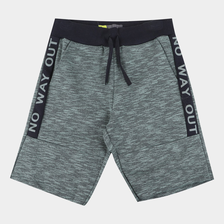

In [71]:
%%time
img_addr = 'https://static.netshoes.com.br/produtos/bermuda-moletom-infantil-lemon-no-way-out-masculina/60/Y64-0190-060/Y64-0190-060_zoom1.jpg?ts=1631732874&ims=326x'

!wget -q -O img.jpg $img_addr
test_img = 'img.jpg'
topK = 4

#np.squeeze : https://www.scaler.com/topics/numpy-squeeze/
test_vec = np.squeeze(module(load_img(test_img)))

basewidth = 224
img = Image.open(test_img)
wpercent = (basewidth/float(img.size[0]))
hsize = int((float(img.size[1])*float(wpercent)))
img = img.resize((basewidth,hsize), Image.ANTIALIAS)
img

Gerando recomendações:

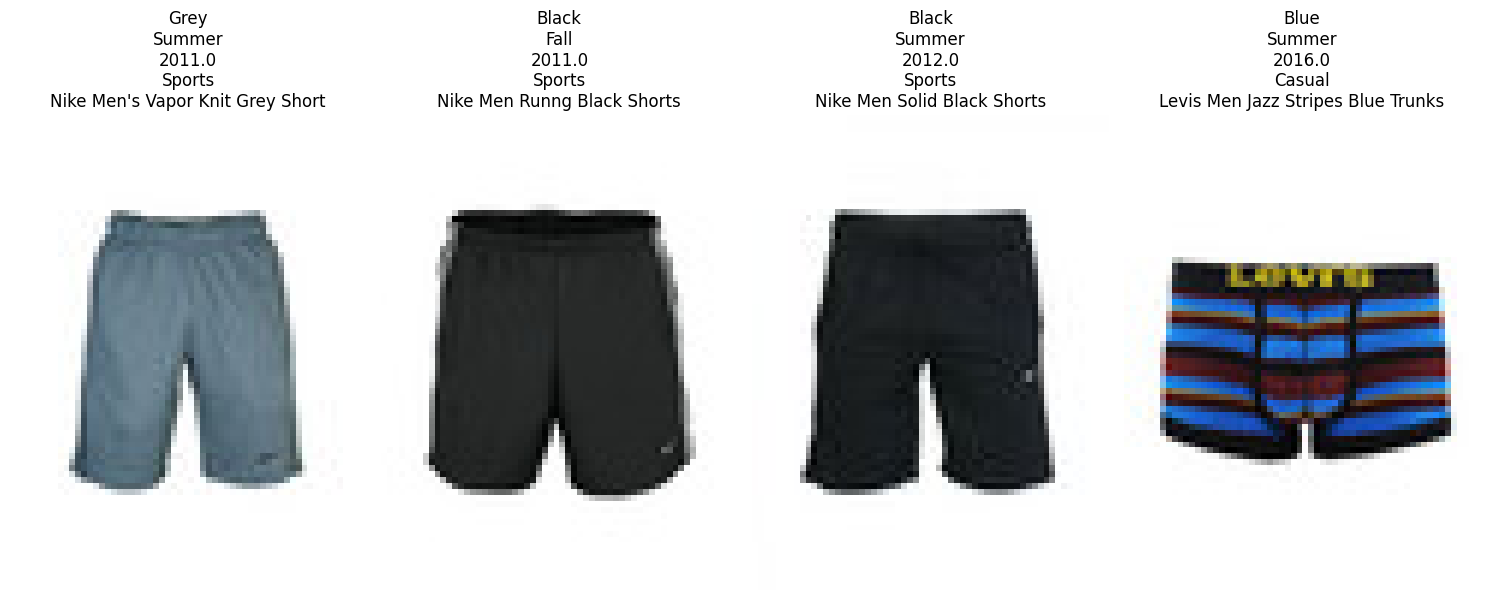

CPU times: user 1.07 s, sys: 140 ms, total: 1.21 s
Wall time: 1.28 s


In [72]:
%%time
path_dict = {}
for path in Path('/content/Fashion_data/categories').rglob('*.jpg'):
  path_dict[path.name] = path

nns = t.get_nns_by_vector(test_vec, n=topK)
plt.figure(figsize=(15, 15))
for i in range(topK):
  x = file_index_to_file_name[nns[i]]
  x = path_dict[x+'.jpg']
  y = file_index_to_product_id[nns[i]]
  title = '\n'.join([str(j) for j in list(styles.loc[y].values[-5:])])
  plt.subplot(1, topK, i+1)
  plt.title(title)
  plt.imshow(mpimg.imread(x))
  plt.axis('off')
plt.tight_layout()
plt.show()